In [1]:
pwd

'/scratch/yl7692'

# 2.Preprocess the Datasets

In [2]:
pip install nibabel

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt

## 1) Visualize the MRI images 

In [47]:
datapath_root = '/scratch/yl7692/training'
SAVE_PATH = '/scratch/yl7692/attention_Unet/'

<ipython-input-5-fe635c2ddc74>:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  T1_weighted_example = nib.load(datapath_root + '/training01/preprocessed/training01_01_mprage_pp.nii').get_data()
<ipython-input-5-fe635c2ddc74>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  T2_weighted_example = nib.load(datapath_root + '/training01/preprocessed/training01_01_t2_pp.nii').get_data()
<ipython-input-5-fe635c2ddc74>:3: DeprecationWarning: get_data() is deprecated in favo

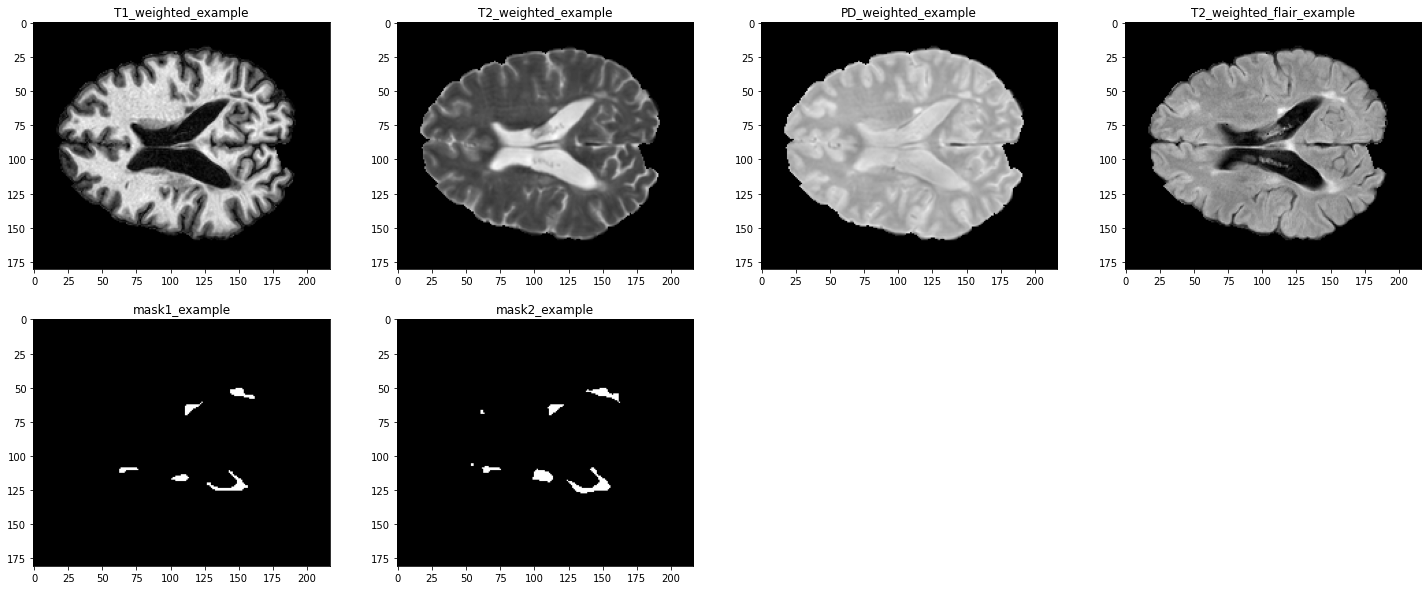

In [5]:
T1_weighted_example = nib.load(datapath_root + '/training01/preprocessed/training01_01_mprage_pp.nii').get_data()
T2_weighted_example = nib.load(datapath_root + '/training01/preprocessed/training01_01_t2_pp.nii').get_data()
PD_weighted_example = nib.load(datapath_root + '/training01/preprocessed/training01_01_pd_pp.nii').get_data()
T2_weighted_flair_example = nib.load(datapath_root + '/training01/preprocessed/training01_01_flair_pp.nii').get_data()
mask1_example = nib.load(datapath_root + '/training01/masks/training01_01_mask1.nii').get_data()
mask2_example = nib.load(datapath_root + '/training01/masks/training01_01_mask2.nii').get_data()
plt.figure(figsize=(25,10))
plt.subplot(2,4,1)
plt.imshow(T1_weighted_example[:,:,90],'gray')
plt.title('T1_weighted_example')
plt.subplot(2,4,2)
plt.imshow(T2_weighted_example[:,:,90],'gray')
plt.title('T2_weighted_example')
plt.subplot(2,4,3)
plt.imshow(PD_weighted_example[:,:,90],'gray')
plt.title('PD_weighted_example')
plt.subplot(2,4,4)
plt.imshow(T2_weighted_flair_example[:,:,90],'gray')
plt.title('T2_weighted_flair_example')
plt.subplot(2,4,5)
plt.imshow(mask1_example[:,:,90],'gray')
plt.title('mask1_example')
plt.subplot(2,4,6)
plt.imshow(mask2_example[:,:,90],'gray')
plt.title('mask2_example')

plt.pause(3)

In [6]:
# ipywidgets for some interactive plots
from ipywidgets.widgets import * 
import ipywidgets as widgets
# slide through dicom images using a slide bar 
def dicom_animation(x):
    plt.figure(figsize=(20,10))
    plt.imshow(T1_weighted_example[:,:,x],'gray')
    return x
interact(dicom_animation, x=(0, len(T1_weighted_example)-1))

interactive(children=(IntSlider(value=90, description='x', max=180), Output()), _dom_classes=('widget-interact…

<function __main__.dicom_animation(x)>

## 2) Define function to process 2 raters' groundtruth  

In [5]:
def weight_ground_truth(mask1_path, mask2_path):
    mask1=nib.load(mask1_path).get_data()
    mask2=nib.load(mask2_path).get_data()
    if mask1.shape==mask2.shape:
        fig_shape = mask1.shape 
    else:
        print('Number inconformity for mask, double check path!')
  
    n=fig_shape[2]

    mask_and_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)
    mask_or_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)
    mask_rnd_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)

    for i in range(n):
        mask_and_weight[:,:,i] = mask1[:,:,i] & mask2[:,:,i]
        mask_or_weight[:,:,i] = mask1[:,:,i] | mask2[:,:,i]
        mask_rnd_weight = (mask_or_weight - mask_and_weight)*np.random.randint(0,2,(fig_shape[0],fig_shape[1],n)) + mask_and_weight


    return mask_and_weight, mask_or_weight, mask_rnd_weight


<ipython-input-7-527bb657da25>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask1=nib.load(mask1_path).get_data()
<ipython-input-7-527bb657da25>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask2=nib.load(mask2_path).get_data()


Text(0.5, 1.0, 'mask_rnd_weight')

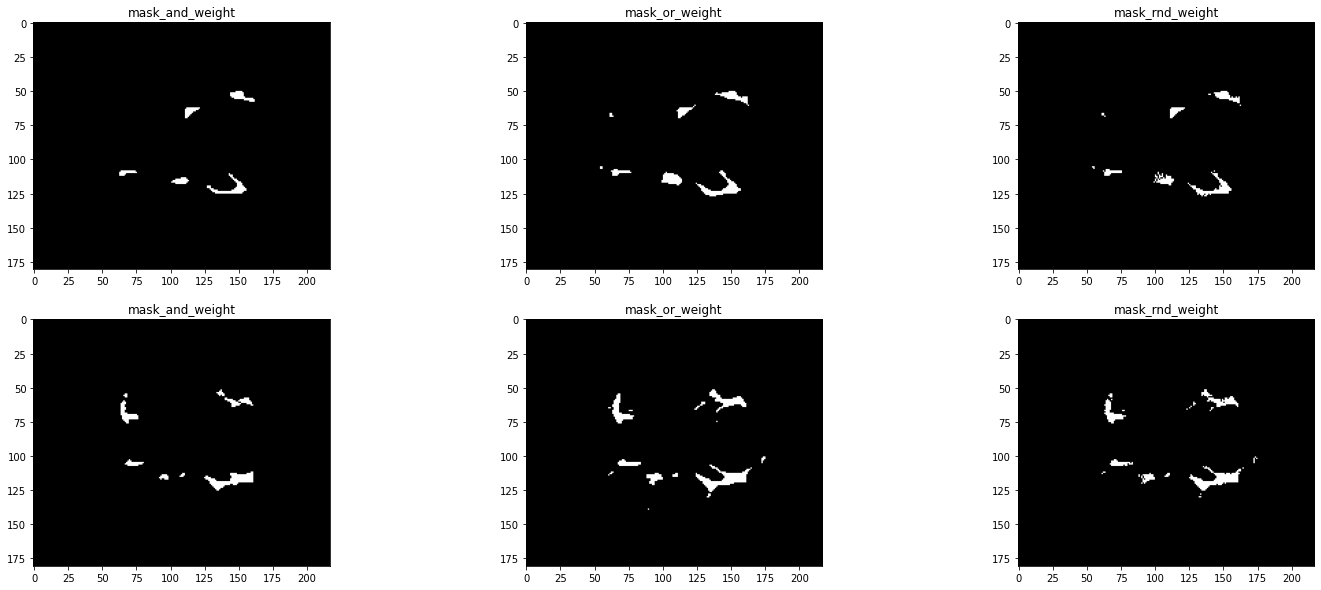

In [8]:
#mask_or_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)
#mask_and_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)
mask1_path = os.path.join(datapath_root,'training01/masks/training01_01_mask1.nii')
mask2_path = os.path.join(datapath_root,'training01/masks/training01_01_mask2.nii')
mask3_path = os.path.join(datapath_root,'training02/masks/training02_02_mask1.nii')
mask4_path = os.path.join(datapath_root,'training02/masks/training02_02_mask2.nii')

mask_and_weight, mask_or_weight, mask_rnd_weight = weight_ground_truth(mask1_path, mask2_path)
mask_and_weight2, mask_or_weight2, mask_rnd_weight2 = weight_ground_truth(mask3_path, mask4_path)

plt.figure(figsize=(25,10))
plt.subplot(2,3,1)
plt.imshow(mask_and_weight[:,:,90],'gray')
plt.title('mask_and_weight')
plt.subplot(2,3,2)
plt.imshow(mask_or_weight[:,:,90],'gray')
plt.title('mask_or_weight')
plt.subplot(2,3,3)
plt.imshow(mask_rnd_weight[:,:,90],'gray')
plt.title('mask_rnd_weight')
plt.subplot(2,3,4)
plt.imshow(mask_and_weight2[:,:,90],'gray')
plt.title('mask_and_weight')
plt.subplot(2,3,5)
plt.imshow(mask_or_weight2[:,:,90],'gray')
plt.title('mask_or_weight')
plt.subplot(2,3,6)
plt.imshow(mask_rnd_weight2[:,:,90],'gray')
plt.title('mask_rnd_weight')

<ipython-input-7-527bb657da25>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask1=nib.load(mask1_path).get_data()
<ipython-input-7-527bb657da25>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask2=nib.load(mask2_path).get_data()


Text(0.5, 1.0, 'mask_rnd_weight')

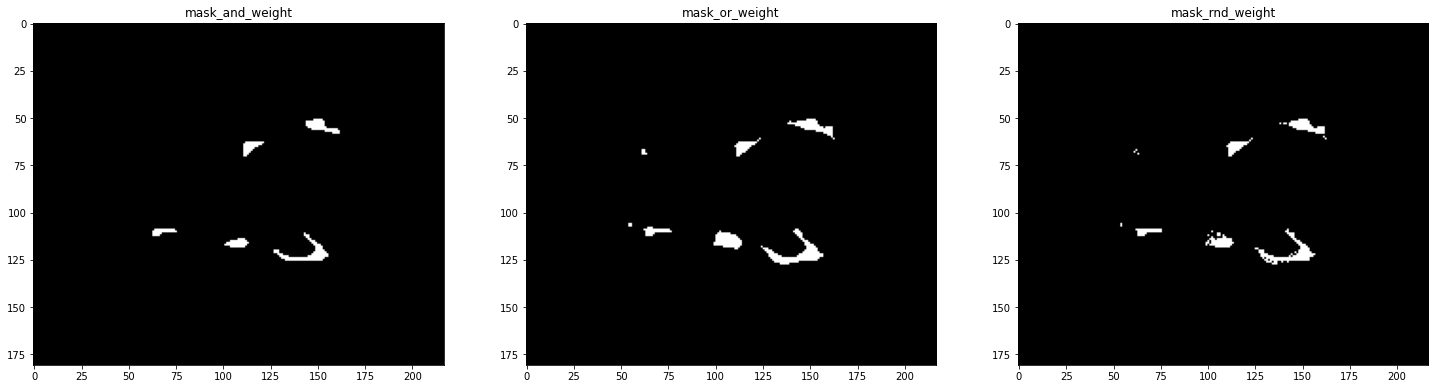

In [9]:
#root = '/content/gdrive/MyDrive/ImageVedioPrecessingProject/training/'
#mask_or_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)
#mask_and_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)
mask_and_weight, mask_or_weight, mask_rnd_weight = weight_ground_truth(mask1_path, mask2_path)
plt.figure(figsize=(25,10))
plt.subplot(1,3,1)
plt.imshow(mask_and_weight[:,:,90],'gray')
plt.title('mask_and_weight')
plt.subplot(1,3,2)
plt.imshow(mask_or_weight[:,:,90],'gray')
plt.title('mask_or_weight')
plt.subplot(1,3,3)
plt.imshow(mask_rnd_weight[:,:,90],'gray')
plt.title('mask_rnd_weight')

## 3) Make the custom dataset

In [7]:
import glob

In [8]:
second_path_list = ['training01/','training02/','training03/','training04/','training05/']
mri_list = []
mask1_list = []
mask2_list = []
for i in range(5):
    timepoint1_path = os.path.join(datapath_root, second_path_list[i], 'preprocessed/*_01_*.nii')
    timepoint2_path = os.path.join(datapath_root, second_path_list[i], 'preprocessed/*_02_*.nii')
    timepoint3_path = os.path.join(datapath_root, second_path_list[i], 'preprocessed/*_03_*.nii')
    timepoint4_path = os.path.join(datapath_root, second_path_list[i], 'preprocessed/*_04_*.nii')
    if i==2:
        timepoint5_path = os.path.join(datapath_root, second_path_list[i], 'preprocessed/*_05_*.nii')
    mask1_path = os.path.join(datapath_root, second_path_list[i], 'masks/*1.nii')
    mask2_path = os.path.join(datapath_root, second_path_list[i], 'masks/*2.nii')
    timepoint1_list = sorted(glob.glob(timepoint1_path))
    timepoint2_list = sorted(glob.glob(timepoint2_path))
    timepoint3_list = sorted(glob.glob(timepoint3_path))
    timepoint4_list = sorted(glob.glob(timepoint4_path))
    if i==2:
        timepoint5_list = sorted(glob.glob(timepoint5_path))
    mri_list.append(timepoint1_list)
    mri_list.append(timepoint2_list)
    mri_list.append(timepoint3_list)
    mri_list.append(timepoint4_list)
    if i==2:
        mri_list.append(timepoint5_list)
    mask1_list = mask1_list + sorted(glob.glob(mask1_path))
    mask2_list = mask2_list + sorted(glob.glob(mask2_path))
print('Data Collected:', len(mri_list))
print('Mask1 Collected:', len(mask1_list))
print('Mask2 Collected:', len(mask2_list))
print(mri_list[0])

Data Collected: 21
Mask1 Collected: 21
Mask2 Collected: 21
['/scratch/yl7692/training/training01/preprocessed/training01_01_flair_pp.nii', '/scratch/yl7692/training/training01/preprocessed/training01_01_mprage_pp.nii', '/scratch/yl7692/training/training01/preprocessed/training01_01_pd_pp.nii', '/scratch/yl7692/training/training01/preprocessed/training01_01_t2_pp.nii']


<ipython-input-13-bbfdd6332bd2>:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  ex = nib.load(mri_list[0][index+i]).get_data()
<ipython-input-13-bbfdd6332bd2>:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  ms1 = nib.load(mask1_list[0]).get_data()
<ipython-input-13-bbfdd6332bd2>:13: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.

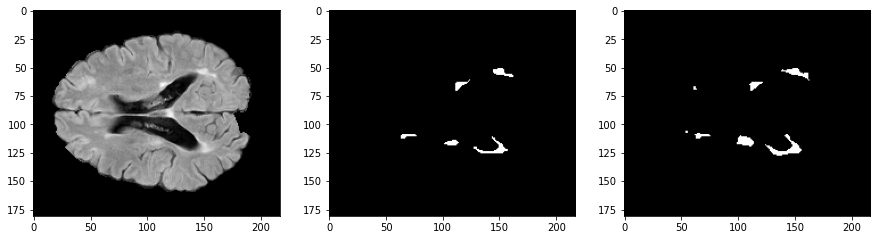

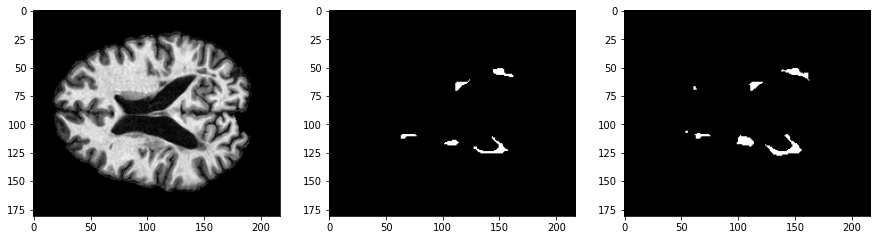

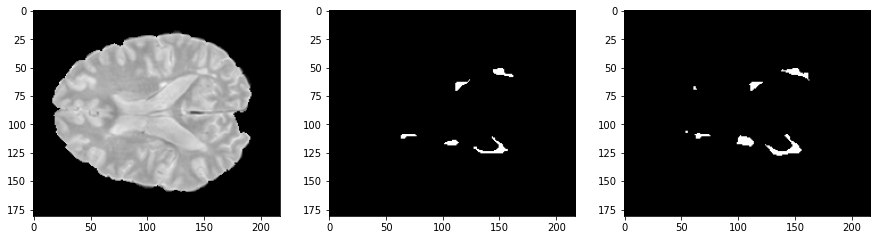

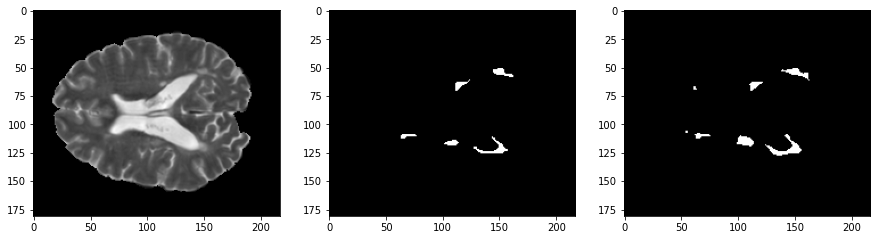

In [13]:
# 0-3:training 1(4 time points)
# 4-7:training 2(4 time points)
# 8-12:training 3(5 time points)
# 13-16:training 4(4 time points)
# 17-20:training 5(4 time points)
# order in one training set: t2_flair_weight, t1_weight, pd_weight, t2_weight

#Display one timepoint(4 type MRI) for one of the training set
index = 0
for i in range(4):
    ex = nib.load(mri_list[0][index+i]).get_data()
    ms1 = nib.load(mask1_list[0]).get_data()
    ms2 = nib.load(mask2_list[0]).get_data()
    plt.figure(figsize=(15,25))
    plt.subplot(5,3,3*i+1)
    plt.imshow(ex[:,:,90],'gray')
    plt.subplot(5,3,3*i+2)
    plt.imshow(ms1[:,:,90],'gray')
    plt.subplot(5,3,3*i+3)
    plt.imshow(ms2[:,:,90],'gray')

In [9]:
from random import shuffle
def shuffle_two_lists(listA, listB, listC):
    temp = list(zip(listA, listB, listC))
    shuffle(temp)
    return zip(*temp)
train_split_ratio = 0.8
test_split_ratio = 0.1
num_samples = len(mri_list)

train_size = int(num_samples * train_split_ratio)
test_size = int(num_samples * test_split_ratio)
val_size = num_samples - train_size - test_size
mri_list_shuffled, mask1_list_shuffled, mask2_list_shuffled = shuffle_two_lists(mri_list, mask1_list, mask2_list)

train_img_list, train_label1_list, train_label2_list = mri_list_shuffled[:train_size], mask1_list_shuffled[:train_size], mask2_list_shuffled[:train_size]
val_img_list, val_label1_list, val_label2_list = mri_list_shuffled[train_size:train_size+ val_size], mask1_list_shuffled[train_size:train_size + val_size], mask2_list_shuffled[train_size:train_size + val_size]
test_img_list, test_label1_list, test_label2_list = mri_list_shuffled[train_size+ val_size:], mask1_list_shuffled[train_size+ val_size:], mask2_list_shuffled[train_size+ val_size:]

print ("Training set size: {}". format(len(train_img_list)))
print ("Validation set size: {}". format(len(val_img_list)))
print ("Test set size: {}". format(len(test_img_list)))

Training set size: 16
Validation set size: 3
Test set size: 2


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from tqdm import tqdm

class MRIDataset(Dataset):
    def __init__(self, img_path_list, label1_path_list, label2_path_list, RULE = 'and', IF_TRAIN= False):
        self.mri_path_list = img_path_list
        self.label1_path_list = label1_path_list
        self.label2_path_list = label2_path_list
        self.rule = RULE
        self.IF_TRAIN = IF_TRAIN
        #self.transform=transforms.Compose([transforms.Normalize((0.5,),(0.5,))])
        self.mri_list, self.mask1_list, self.mask2_list, self.mask_and_list, self.mask_or_list, self.mask_rnd_list = self.preprocess() 

    def __len__(self):
        return len(self.mri_list)

    def preprocess(self):
        mri_list, mask1_list, mask2_list, mask_and_list, mask_or_list, mask_rnd_list = [], [], [], [], [], []
        for idx in tqdm(range(len(self.mri_path_list))):
            mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
            mri_t2f = (mri_t2f-mri_t2f.min())/(mri_t2f.max()-mri_t2f.min())
            
            mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
            mri_t1w = (mri_t1w-mri_t1w.min())/(mri_t1w.max()-mri_t1w.min())
            
            mri_pd = torch.Tensor(nib.load(self.mri_path_list[idx][2]).get_data())
            mri_pd = (mri_pd-mri_pd.min())/(mri_pd.max()-mri_pd.min())
            
            mri_t2w = torch.Tensor(nib.load(self.mri_path_list[idx][3]).get_data())
            mri_t2w = (mri_t2w-mri_t2w.min())/(mri_t2w.max()-mri_t2w.min())
            
            mri = torch.cat((mri_t1w.unsqueeze(0),mri_t2w.unsqueeze(0),mri_pd.unsqueeze(0),mri_t2f.unsqueeze(0)),axis=0)
            #mri = self.transform(mri)
            mask_and, mask_or, mask_rnd = weight_ground_truth(self.label1_path_list[idx], self.label2_path_list[idx])
            mask1 = torch.Tensor(nib.load(self.label1_path_list[idx]).get_data())
            mask2 = torch.Tensor(nib.load(self.label2_path_list[idx]).get_data())
            
            mri_list.append(mri)
            mask1_list.append(mask1)
            mask2_list.append(mask2)
            mask_and_list.append(mask_and)
            mask_or_list.append(mask_or)
            mask_rnd_list.append(mask_rnd)
        return mri_list, mask1_list, mask2_list, mask_and_list, mask_or_list, mask_rnd_list

    def __getitem__ (self,idx):
        img = self.mri_list[idx]
        if self.rule=='and':
            mask = self.mask_and_list[idx]
        elif self.rule=='or':
            mask = self.mask_or_list[idx]
        elif self.rule=='random':
            mask = self.mask_rnd_list[idx]
        elif self.rule=='mask1':
            mask = self.mask1_list[idx]
        elif self.rule=='mask2':
            mask = self.mask2_list[idx]
            
        label = torch.Tensor(mask)

        return img, label

In [16]:
dataset = MRIDataset(test_img_list, test_label1_list, test_label2_list, RULE = 'and', IF_TRAIN= True)

  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-15-976d5a4983b3>:25: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
<ipython-input-15-976d5a4983b3>:28: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
<ipython-input-15-976d5a4983b3>:31: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more pr

torch.Size([4, 181, 217, 181])
torch.Size([181, 217, 181])
1.0
1.0
1.0
1.0


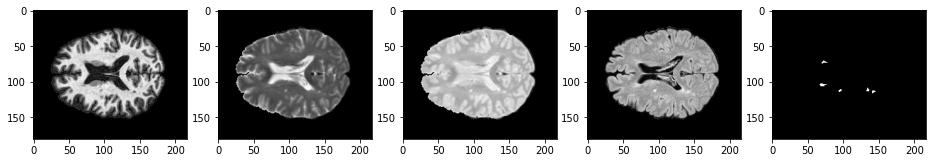

In [17]:
img, mask = dataset[0]
print(img.shape)
print(mask.shape)
plt.figure(figsize = (16,32))
plt.subplot(1,5,1)
plt.imshow(img[0,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.subplot(1,5,2)
plt.imshow(img[1,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.subplot(1,5,3)
plt.imshow(img[2,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.subplot(1,5,4)
plt.imshow(img[3,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.subplot(1,5,5)
plt.imshow(mask.cpu().numpy()[:,:,90],'gray')
print(img[0,:,:,:].cpu().numpy().max())
print(img[1,:,:,:].cpu().numpy().max())
print(img[2,:,:,:].cpu().numpy().max())
print(img[3,:,:,:].cpu().numpy().max())

In [11]:
train_dataset = MRIDataset(train_img_list, train_label1_list, train_label2_list, RULE = 'and', IF_TRAIN= True)
val_dataset = MRIDataset(val_img_list, val_label1_list, val_label2_list, RULE = 'and', IF_TRAIN= False)
test_dataset = MRIDataset(test_img_list, test_label1_list, test_label2_list, RULE = 'and', IF_TRAIN= False)

  0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-10-976d5a4983b3>:25: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
<ipython-input-10-976d5a4983b3>:28: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
<ipython-input-10-976d5a4983b3>:31: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more p

In [40]:
NUM_EPOCH = 100
BATCH_SIZE = 4
LR = 0.0005


In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         num_workers=0)

# 3.Build the Network

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x
    
class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv3d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x
    
    
class Attention_block(nn.Module):
    """
    Attention Block
    """

    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

    
class AttU_Net(nn.Module):
    """
    Attention Unet implementation
    Paper: https://arxiv.org/abs/1804.03999
    """
    def __init__(self, img_ch=4, output_ch=1):
        super(AttU_Net, self).__init__()

        n1 = 8
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
        #filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
        self.Maxpool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv3d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)

        #self.active = torch.nn.Sigmoid()


    def forward(self, x):

        e1 = self.Conv1(x)
        #print("e1", e1.shape)
        e2 = self.Maxpool1((e1))
        e2 = self.Conv2(e2)
        #print("e2", e2.shape)
        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)
        #print("e3", e3.shape)
        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)
        #print("e4", e4.shape)
        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)
        #print("e5", e5.shape)
        #print(x5.shape)
        d5 = self.Up5(e5)
        #print(d5.shape)
        e4 = e4[:,:,:,0:-1,:]
        #print("e4 new", e4.shape)
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        e3 = e3[:,:,0:-1,0:-2,0:-1]
        #print("e3 new", e3.shape)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        e2 = e2[:,:,0:-2,0:-4,0:-2]
        #print("e2 new", e2.shape)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        #print("d2", d2.shape)
        padding = nn.ConstantPad3d(((2, 3, 4, 5, 2, 3)), 0)
        d2 = padding(d2)
        #print("d2 new", d2.shape)
        #print("e1", e1.shape)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)


      #  out = self.active(out)

        return out

# 4.Dice Loss

In [43]:
# define dice coefficient
def dice_coeff(pred, target):
    smooth = 1
    # First let's flatten the matrix to [Batch Size, -1]
    # The flatten operation does not afftect the computation of the above equation
    num = pred.size(0)
    m1 = pred. view(num, -1). float() # Flatten
    m2 = target. view(num, -1). float() # Flatten
    # Then we compute the intersection and the sum of cardinality
    intersection = 2*torch.sum(m1*m2,dim= 1) + smooth
    cardinality = torch.sum(m1**2,dim= 1) + torch.sum(m2**2,dim= 1) + smooth
    # Followed by Dice
    dice = intersection/cardinality
    return dice.mean()
# define SoftDICE loss as 1 - SoftDICE
class SoftDICELoss(nn. Module):
    def __init__(self, smooth = 1):
        super(SoftDICELoss, self). __init__()
        self. smooth = smooth
    def forward(self, pred, target):
        loss = 1 - dice_coeff(pred, target)
        return loss.mean()

# 5.Training

In [17]:
def train_epoch(net, data_loader, optimizer, criterion, epoch):

    net = net.train()
    optimizer.zero_grad()
    loss_stat = []
    for i, img_mask in enumerate(data_loader):
        img, mask = img_mask

        img = img.to(device)
        mask = mask.to(device)

        pred = net(img)

        loss = criterion(pred, mask)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_stat += [loss.item()]*img.shape[0]
        print ("Epoch {}: [{}/{}] Loss: {:.3f}". format(epoch, len(data_loader), len(data_loader),np. mean(loss_stat)))
    return np.mean(loss_stat)

In [18]:
def eval_epoch(net, data_loader, metric, criterion):
    # set model in eval mode to avoid updating BN layer
    net = net.eval()
    
    metric_stat = []
    val_loss_stat = []
    for i, img_mask in enumerate(data_loader):
        img, mask = img_mask
        # send data to device
        img = img.to(device)
        mask = mask.to(device)
        # feed data to the model. No need to compute grad.
        with torch.no_grad():
            pred = net(img)
            val_loss = criterion(pred, mask)
            
        # eval the results using DICE function as the metric
        # Convert probability to prediction mask
        pred = pred>0.2
        err = dice_coeff(pred, mask)
        metric_stat += [err.item()]*img.shape[0]
        val_loss_stat += [val_loss.item()]*img.shape[0]
        
    print ("Dice: {:.3f}  Val Loss: {:.3f} ".format(np.mean(metric_stat), np.mean(val_loss_stat)))
    
    return np.mean(val_loss_stat), np.mean(metric_stat)

In [44]:
net = AttU_Net(4,1).to(device)
print(net)
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

AttU_Net(
  (Maxpool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05,

In [45]:
optimizer = optim.Adam(net.parameters(), lr= LR)
criterion = SoftDICELoss()

train_loss_list = []
val_loss_list = []
dice_list = []

In [48]:
for epoch in tqdm(range(NUM_EPOCH)):    
    loss = train_epoch(net, train_loader, optimizer, criterion, epoch)
    val_loss, dice = eval_epoch(net, val_loader, dice_coeff, criterion)
    
    # Record losses for each epoch
    train_loss_list.append(loss)
    val_loss_list.append(val_loss)
    dice_list.append(dice)
    
    # Save the model after each epoch
    if os.path.isdir(SAVE_PATH):
        torch.save(net.state_dict(),SAVE_PATH + 'MRISegEpoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(SAVE_PATH, exist_ok=True)
        torch.save(net.state_dict(),SAVE_PATH + 'MRISegEpoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved to {}'.format(epoch + 1, SAVE_PATH + 'MRISegEpoch{}.pth'.format(epoch + 1)))  

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: [4/4] Loss: 0.987
Epoch 0: [4/4] Loss: 0.988
Epoch 0: [4/4] Loss: 0.983
Epoch 0: [4/4] Loss: 0.977


  1%|          | 1/100 [01:03<1:44:19, 63.22s/it]

Dice: 0.000  Val Loss: 1.002 
Checkpoint 1 saved to /scratch/yl7692/attention_Unet/MRISegEpoch1.pth
Epoch 1: [4/4] Loss: 0.973
Epoch 1: [4/4] Loss: 0.977
Epoch 1: [4/4] Loss: 0.975
Epoch 1: [4/4] Loss: 0.968


  2%|▏         | 2/100 [02:06<1:43:09, 63.16s/it]

Dice: 0.000  Val Loss: 1.002 
Checkpoint 2 saved to /scratch/yl7692/attention_Unet/MRISegEpoch2.pth
Epoch 2: [4/4] Loss: 0.977
Epoch 2: [4/4] Loss: 0.979
Epoch 2: [4/4] Loss: 0.969
Epoch 2: [4/4] Loss: 0.956


  3%|▎         | 3/100 [03:09<1:42:06, 63.16s/it]

Dice: 0.000  Val Loss: 1.002 
Checkpoint 3 saved to /scratch/yl7692/attention_Unet/MRISegEpoch3.pth
Epoch 3: [4/4] Loss: 0.938
Epoch 3: [4/4] Loss: 0.925
Epoch 3: [4/4] Loss: 0.934
Epoch 3: [4/4] Loss: 0.933


  4%|▍         | 4/100 [04:12<1:41:04, 63.17s/it]

Dice: 0.000  Val Loss: 1.003 
Checkpoint 4 saved to /scratch/yl7692/attention_Unet/MRISegEpoch4.pth
Epoch 4: [4/4] Loss: 0.916
Epoch 4: [4/4] Loss: 0.933
Epoch 4: [4/4] Loss: 0.922
Epoch 4: [4/4] Loss: 0.911


  5%|▌         | 5/100 [05:15<1:40:01, 63.17s/it]

Dice: 0.000  Val Loss: 1.003 
Checkpoint 5 saved to /scratch/yl7692/attention_Unet/MRISegEpoch5.pth
Epoch 5: [4/4] Loss: 0.860
Epoch 5: [4/4] Loss: 0.890
Epoch 5: [4/4] Loss: 0.910
Epoch 5: [4/4] Loss: 0.888


  6%|▌         | 6/100 [06:19<1:38:59, 63.19s/it]

Dice: 0.001  Val Loss: 1.001 
Checkpoint 6 saved to /scratch/yl7692/attention_Unet/MRISegEpoch6.pth
Epoch 6: [4/4] Loss: 0.870
Epoch 6: [4/4] Loss: 0.853
Epoch 6: [4/4] Loss: 0.881
Epoch 6: [4/4] Loss: 0.867


  7%|▋         | 7/100 [07:22<1:37:55, 63.18s/it]

Dice: 0.025  Val Loss: 1.001 
Checkpoint 7 saved to /scratch/yl7692/attention_Unet/MRISegEpoch7.pth
Epoch 7: [4/4] Loss: 0.929
Epoch 7: [4/4] Loss: 0.912
Epoch 7: [4/4] Loss: 0.874
Epoch 7: [4/4] Loss: 0.850


  8%|▊         | 8/100 [08:25<1:36:51, 63.16s/it]

Dice: 0.062  Val Loss: 1.001 
Checkpoint 8 saved to /scratch/yl7692/attention_Unet/MRISegEpoch8.pth
Epoch 8: [4/4] Loss: 0.816
Epoch 8: [4/4] Loss: 0.795
Epoch 8: [4/4] Loss: 0.809
Epoch 8: [4/4] Loss: 0.829


  9%|▉         | 9/100 [09:28<1:35:45, 63.14s/it]

Dice: 0.019  Val Loss: 1.002 
Checkpoint 9 saved to /scratch/yl7692/attention_Unet/MRISegEpoch9.pth
Epoch 9: [4/4] Loss: 0.869
Epoch 9: [4/4] Loss: 0.830
Epoch 9: [4/4] Loss: 0.812
Epoch 9: [4/4] Loss: 0.808


 10%|█         | 10/100 [10:31<1:34:42, 63.14s/it]

Dice: 0.220  Val Loss: 1.001 
Checkpoint 10 saved to /scratch/yl7692/attention_Unet/MRISegEpoch10.pth
Epoch 10: [4/4] Loss: 0.785
Epoch 10: [4/4] Loss: 0.750
Epoch 10: [4/4] Loss: 0.795
Epoch 10: [4/4] Loss: 0.810


 11%|█         | 11/100 [11:34<1:33:39, 63.14s/it]

Dice: 0.158  Val Loss: 1.000 
Checkpoint 11 saved to /scratch/yl7692/attention_Unet/MRISegEpoch11.pth
Epoch 11: [4/4] Loss: 0.752
Epoch 11: [4/4] Loss: 0.785
Epoch 11: [4/4] Loss: 0.772
Epoch 11: [4/4] Loss: 0.774


 12%|█▏        | 12/100 [12:37<1:32:37, 63.15s/it]

Dice: 0.300  Val Loss: 0.911 
Checkpoint 12 saved to /scratch/yl7692/attention_Unet/MRISegEpoch12.pth
Epoch 12: [4/4] Loss: 0.797
Epoch 12: [4/4] Loss: 0.807
Epoch 12: [4/4] Loss: 0.770
Epoch 12: [4/4] Loss: 0.751


 13%|█▎        | 13/100 [13:41<1:31:36, 63.18s/it]

Dice: 0.453  Val Loss: 0.964 
Checkpoint 13 saved to /scratch/yl7692/attention_Unet/MRISegEpoch13.pth
Epoch 13: [4/4] Loss: 0.721
Epoch 13: [4/4] Loss: 0.755
Epoch 13: [4/4] Loss: 0.755
Epoch 13: [4/4] Loss: 0.734


 14%|█▍        | 14/100 [14:44<1:30:32, 63.17s/it]

Dice: 0.049  Val Loss: 0.934 
Checkpoint 14 saved to /scratch/yl7692/attention_Unet/MRISegEpoch14.pth
Epoch 14: [4/4] Loss: 0.787
Epoch 14: [4/4] Loss: 0.725
Epoch 14: [4/4] Loss: 0.746
Epoch 14: [4/4] Loss: 0.718


 15%|█▌        | 15/100 [15:47<1:29:30, 63.18s/it]

Dice: 0.013  Val Loss: 0.967 
Checkpoint 15 saved to /scratch/yl7692/attention_Unet/MRISegEpoch15.pth
Epoch 15: [4/4] Loss: 0.769
Epoch 15: [4/4] Loss: 0.664
Epoch 15: [4/4] Loss: 0.643
Epoch 15: [4/4] Loss: 0.652


 16%|█▌        | 16/100 [16:50<1:28:25, 63.16s/it]

Dice: 0.071  Val Loss: 0.869 
Checkpoint 16 saved to /scratch/yl7692/attention_Unet/MRISegEpoch16.pth
Epoch 16: [4/4] Loss: 0.470
Epoch 16: [4/4] Loss: 0.509
Epoch 16: [4/4] Loss: 0.565
Epoch 16: [4/4] Loss: 0.572


 17%|█▋        | 17/100 [17:53<1:27:20, 63.14s/it]

Dice: 0.074  Val Loss: 0.825 
Checkpoint 17 saved to /scratch/yl7692/attention_Unet/MRISegEpoch17.pth
Epoch 17: [4/4] Loss: 0.505
Epoch 17: [4/4] Loss: 0.483
Epoch 17: [4/4] Loss: 0.493
Epoch 17: [4/4] Loss: 0.519


 18%|█▊        | 18/100 [18:56<1:26:16, 63.13s/it]

Dice: 0.474  Val Loss: 0.769 
Checkpoint 18 saved to /scratch/yl7692/attention_Unet/MRISegEpoch18.pth
Epoch 18: [4/4] Loss: 0.512
Epoch 18: [4/4] Loss: 0.488
Epoch 18: [4/4] Loss: 0.511
Epoch 18: [4/4] Loss: 0.492


 19%|█▉        | 19/100 [19:59<1:25:13, 63.13s/it]

Dice: 0.346  Val Loss: 0.817 
Checkpoint 19 saved to /scratch/yl7692/attention_Unet/MRISegEpoch19.pth
Epoch 19: [4/4] Loss: 0.330
Epoch 19: [4/4] Loss: 0.416
Epoch 19: [4/4] Loss: 0.432
Epoch 19: [4/4] Loss: 0.480


 20%|██        | 20/100 [21:03<1:24:10, 63.13s/it]

Dice: 0.145  Val Loss: 0.773 
Checkpoint 20 saved to /scratch/yl7692/attention_Unet/MRISegEpoch20.pth
Epoch 20: [4/4] Loss: 0.448
Epoch 20: [4/4] Loss: 0.438
Epoch 20: [4/4] Loss: 0.432
Epoch 20: [4/4] Loss: 0.416


 21%|██        | 21/100 [22:06<1:23:06, 63.12s/it]

Dice: 0.503  Val Loss: 0.618 
Checkpoint 21 saved to /scratch/yl7692/attention_Unet/MRISegEpoch21.pth
Epoch 21: [4/4] Loss: 0.283
Epoch 21: [4/4] Loss: 0.396
Epoch 21: [4/4] Loss: 0.421
Epoch 21: [4/4] Loss: 0.407


 22%|██▏       | 22/100 [23:09<1:22:02, 63.11s/it]

Dice: 0.594  Val Loss: 0.848 
Checkpoint 22 saved to /scratch/yl7692/attention_Unet/MRISegEpoch22.pth
Epoch 22: [4/4] Loss: 0.308
Epoch 22: [4/4] Loss: 0.341
Epoch 22: [4/4] Loss: 0.330
Epoch 22: [4/4] Loss: 0.321


 23%|██▎       | 23/100 [24:12<1:21:01, 63.13s/it]

Dice: 0.246  Val Loss: 0.548 
Checkpoint 23 saved to /scratch/yl7692/attention_Unet/MRISegEpoch23.pth
Epoch 23: [4/4] Loss: 0.315
Epoch 23: [4/4] Loss: 0.347
Epoch 23: [4/4] Loss: 0.324
Epoch 23: [4/4] Loss: 0.316


 24%|██▍       | 24/100 [25:15<1:19:57, 63.13s/it]

Dice: 0.557  Val Loss: 0.531 
Checkpoint 24 saved to /scratch/yl7692/attention_Unet/MRISegEpoch24.pth
Epoch 24: [4/4] Loss: 0.298
Epoch 24: [4/4] Loss: 0.298
Epoch 24: [4/4] Loss: 0.291
Epoch 24: [4/4] Loss: 0.308


 25%|██▌       | 25/100 [26:18<1:18:55, 63.14s/it]

Dice: 0.474  Val Loss: 0.421 
Checkpoint 25 saved to /scratch/yl7692/attention_Unet/MRISegEpoch25.pth
Epoch 25: [4/4] Loss: 0.264
Epoch 25: [4/4] Loss: 0.259
Epoch 25: [4/4] Loss: 0.280
Epoch 25: [4/4] Loss: 0.283


 26%|██▌       | 26/100 [27:21<1:17:51, 63.12s/it]

Dice: 0.463  Val Loss: 0.406 
Checkpoint 26 saved to /scratch/yl7692/attention_Unet/MRISegEpoch26.pth
Epoch 26: [4/4] Loss: 0.262
Epoch 26: [4/4] Loss: 0.253
Epoch 26: [4/4] Loss: 0.251
Epoch 26: [4/4] Loss: 0.261


 27%|██▋       | 27/100 [28:24<1:16:48, 63.13s/it]

Dice: 0.661  Val Loss: 0.491 
Checkpoint 27 saved to /scratch/yl7692/attention_Unet/MRISegEpoch27.pth
Epoch 27: [4/4] Loss: 0.434
Epoch 27: [4/4] Loss: 0.335
Epoch 27: [4/4] Loss: 0.310
Epoch 27: [4/4] Loss: 0.303


 28%|██▊       | 28/100 [29:28<1:15:45, 63.13s/it]

Dice: 0.636  Val Loss: 0.355 
Checkpoint 28 saved to /scratch/yl7692/attention_Unet/MRISegEpoch28.pth
Epoch 28: [4/4] Loss: 0.272
Epoch 28: [4/4] Loss: 0.256
Epoch 28: [4/4] Loss: 0.257
Epoch 28: [4/4] Loss: 0.258


 29%|██▉       | 29/100 [30:31<1:14:41, 63.11s/it]

Dice: 0.677  Val Loss: 0.305 
Checkpoint 29 saved to /scratch/yl7692/attention_Unet/MRISegEpoch29.pth
Epoch 29: [4/4] Loss: 0.237
Epoch 29: [4/4] Loss: 0.231
Epoch 29: [4/4] Loss: 0.296
Epoch 29: [4/4] Loss: 0.277


 30%|███       | 30/100 [31:34<1:13:39, 63.14s/it]

Dice: 0.742  Val Loss: 0.561 
Checkpoint 30 saved to /scratch/yl7692/attention_Unet/MRISegEpoch30.pth
Epoch 30: [4/4] Loss: 0.232
Epoch 30: [4/4] Loss: 0.246
Epoch 30: [4/4] Loss: 0.250
Epoch 30: [4/4] Loss: 0.254


 31%|███       | 31/100 [32:37<1:12:36, 63.13s/it]

Dice: 0.613  Val Loss: 0.280 
Checkpoint 31 saved to /scratch/yl7692/attention_Unet/MRISegEpoch31.pth
Epoch 31: [4/4] Loss: 0.221
Epoch 31: [4/4] Loss: 0.286
Epoch 31: [4/4] Loss: 0.256
Epoch 31: [4/4] Loss: 0.254


 32%|███▏      | 32/100 [33:40<1:11:32, 63.12s/it]

Dice: 0.537  Val Loss: 0.312 
Checkpoint 32 saved to /scratch/yl7692/attention_Unet/MRISegEpoch32.pth
Epoch 32: [4/4] Loss: 0.212
Epoch 32: [4/4] Loss: 0.309
Epoch 32: [4/4] Loss: 0.279
Epoch 32: [4/4] Loss: 0.262


 33%|███▎      | 33/100 [34:43<1:10:28, 63.12s/it]

Dice: 0.705  Val Loss: 0.380 
Checkpoint 33 saved to /scratch/yl7692/attention_Unet/MRISegEpoch33.pth
Epoch 33: [4/4] Loss: 0.240
Epoch 33: [4/4] Loss: 0.280
Epoch 33: [4/4] Loss: 0.271
Epoch 33: [4/4] Loss: 0.263


 34%|███▍      | 34/100 [35:46<1:09:26, 63.13s/it]

Dice: 0.484  Val Loss: 0.330 
Checkpoint 34 saved to /scratch/yl7692/attention_Unet/MRISegEpoch34.pth
Epoch 34: [4/4] Loss: 0.191
Epoch 34: [4/4] Loss: 0.195
Epoch 34: [4/4] Loss: 0.224
Epoch 34: [4/4] Loss: 0.284


 35%|███▌      | 35/100 [36:49<1:08:23, 63.13s/it]

Dice: 0.162  Val Loss: 0.522 
Checkpoint 35 saved to /scratch/yl7692/attention_Unet/MRISegEpoch35.pth
Epoch 35: [4/4] Loss: 0.200
Epoch 35: [4/4] Loss: 0.222
Epoch 35: [4/4] Loss: 0.223
Epoch 35: [4/4] Loss: 0.237


 36%|███▌      | 36/100 [37:53<1:07:20, 63.13s/it]

Dice: 0.370  Val Loss: 0.378 
Checkpoint 36 saved to /scratch/yl7692/attention_Unet/MRISegEpoch36.pth
Epoch 36: [4/4] Loss: 0.230
Epoch 36: [4/4] Loss: 0.222
Epoch 36: [4/4] Loss: 0.262
Epoch 36: [4/4] Loss: 0.252


 37%|███▋      | 37/100 [38:56<1:06:19, 63.17s/it]

Dice: 0.712  Val Loss: 0.379 
Checkpoint 37 saved to /scratch/yl7692/attention_Unet/MRISegEpoch37.pth
Epoch 37: [4/4] Loss: 0.241
Epoch 37: [4/4] Loss: 0.218
Epoch 37: [4/4] Loss: 0.212
Epoch 37: [4/4] Loss: 0.214


 38%|███▊      | 38/100 [39:59<1:05:16, 63.16s/it]

Dice: 0.390  Val Loss: 0.327 
Checkpoint 38 saved to /scratch/yl7692/attention_Unet/MRISegEpoch38.pth
Epoch 38: [4/4] Loss: 0.214
Epoch 38: [4/4] Loss: 0.231
Epoch 38: [4/4] Loss: 0.229
Epoch 38: [4/4] Loss: 0.221


 39%|███▉      | 39/100 [41:02<1:04:12, 63.15s/it]

Dice: 0.566  Val Loss: 0.274 
Checkpoint 39 saved to /scratch/yl7692/attention_Unet/MRISegEpoch39.pth
Epoch 39: [4/4] Loss: 0.178
Epoch 39: [4/4] Loss: 0.203
Epoch 39: [4/4] Loss: 0.201
Epoch 39: [4/4] Loss: 0.200


 40%|████      | 40/100 [42:05<1:03:09, 63.15s/it]

Dice: 0.736  Val Loss: 0.243 
Checkpoint 40 saved to /scratch/yl7692/attention_Unet/MRISegEpoch40.pth
Epoch 40: [4/4] Loss: 0.191
Epoch 40: [4/4] Loss: 0.213
Epoch 40: [4/4] Loss: 0.206
Epoch 40: [4/4] Loss: 0.197


 41%|████      | 41/100 [43:08<1:02:06, 63.16s/it]

Dice: 0.744  Val Loss: 0.266 
Checkpoint 41 saved to /scratch/yl7692/attention_Unet/MRISegEpoch41.pth
Epoch 41: [4/4] Loss: 0.175
Epoch 41: [4/4] Loss: 0.180
Epoch 41: [4/4] Loss: 0.176
Epoch 41: [4/4] Loss: 0.181


 42%|████▏     | 42/100 [44:12<1:01:03, 63.16s/it]

Dice: 0.731  Val Loss: 0.241 
Checkpoint 42 saved to /scratch/yl7692/attention_Unet/MRISegEpoch42.pth
Epoch 42: [4/4] Loss: 0.215
Epoch 42: [4/4] Loss: 0.222
Epoch 42: [4/4] Loss: 0.218
Epoch 42: [4/4] Loss: 0.220


 43%|████▎     | 43/100 [45:15<59:59, 63.16s/it]  

Dice: 0.739  Val Loss: 0.301 
Checkpoint 43 saved to /scratch/yl7692/attention_Unet/MRISegEpoch43.pth
Epoch 43: [4/4] Loss: 0.214
Epoch 43: [4/4] Loss: 0.267
Epoch 43: [4/4] Loss: 0.241
Epoch 43: [4/4] Loss: 0.233


 44%|████▍     | 44/100 [46:18<58:55, 63.14s/it]

Dice: 0.747  Val Loss: 0.321 
Checkpoint 44 saved to /scratch/yl7692/attention_Unet/MRISegEpoch44.pth
Epoch 44: [4/4] Loss: 0.222
Epoch 44: [4/4] Loss: 0.204
Epoch 44: [4/4] Loss: 0.200
Epoch 44: [4/4] Loss: 0.226


 45%|████▌     | 45/100 [47:21<57:52, 63.13s/it]

Dice: 0.768  Val Loss: 0.325 
Checkpoint 45 saved to /scratch/yl7692/attention_Unet/MRISegEpoch45.pth
Epoch 45: [4/4] Loss: 0.200
Epoch 45: [4/4] Loss: 0.206
Epoch 45: [4/4] Loss: 0.196
Epoch 45: [4/4] Loss: 0.204


 46%|████▌     | 46/100 [48:24<56:49, 63.15s/it]

Dice: 0.727  Val Loss: 0.256 
Checkpoint 46 saved to /scratch/yl7692/attention_Unet/MRISegEpoch46.pth
Epoch 46: [4/4] Loss: 0.214
Epoch 46: [4/4] Loss: 0.205
Epoch 46: [4/4] Loss: 0.209
Epoch 46: [4/4] Loss: 0.201


 47%|████▋     | 47/100 [49:27<55:47, 63.15s/it]

Dice: 0.724  Val Loss: 0.267 
Checkpoint 47 saved to /scratch/yl7692/attention_Unet/MRISegEpoch47.pth
Epoch 47: [4/4] Loss: 0.180
Epoch 47: [4/4] Loss: 0.178
Epoch 47: [4/4] Loss: 0.227
Epoch 47: [4/4] Loss: 0.228


 48%|████▊     | 48/100 [50:30<54:43, 63.14s/it]

Dice: 0.775  Val Loss: 0.366 
Checkpoint 48 saved to /scratch/yl7692/attention_Unet/MRISegEpoch48.pth
Epoch 48: [4/4] Loss: 0.198
Epoch 48: [4/4] Loss: 0.210
Epoch 48: [4/4] Loss: 0.203
Epoch 48: [4/4] Loss: 0.207


 49%|████▉     | 49/100 [51:34<53:40, 63.14s/it]

Dice: 0.397  Val Loss: 0.547 
Checkpoint 49 saved to /scratch/yl7692/attention_Unet/MRISegEpoch49.pth
Epoch 49: [4/4] Loss: 0.174
Epoch 49: [4/4] Loss: 0.209
Epoch 49: [4/4] Loss: 0.204
Epoch 49: [4/4] Loss: 0.221


 50%|█████     | 50/100 [52:37<52:37, 63.15s/it]

Dice: 0.706  Val Loss: 0.535 
Checkpoint 50 saved to /scratch/yl7692/attention_Unet/MRISegEpoch50.pth
Epoch 50: [4/4] Loss: 0.214
Epoch 50: [4/4] Loss: 0.220
Epoch 50: [4/4] Loss: 0.240
Epoch 50: [4/4] Loss: 0.228


 51%|█████     | 51/100 [53:40<51:34, 63.15s/it]

Dice: 0.760  Val Loss: 0.374 
Checkpoint 51 saved to /scratch/yl7692/attention_Unet/MRISegEpoch51.pth
Epoch 51: [4/4] Loss: 0.181
Epoch 51: [4/4] Loss: 0.192
Epoch 51: [4/4] Loss: 0.210
Epoch 51: [4/4] Loss: 0.207


 52%|█████▏    | 52/100 [54:43<50:31, 63.15s/it]

Dice: 0.755  Val Loss: 0.302 
Checkpoint 52 saved to /scratch/yl7692/attention_Unet/MRISegEpoch52.pth
Epoch 52: [4/4] Loss: 0.184
Epoch 52: [4/4] Loss: 0.192
Epoch 52: [4/4] Loss: 0.186
Epoch 52: [4/4] Loss: 0.183


 53%|█████▎    | 53/100 [55:46<49:28, 63.16s/it]

Dice: 0.660  Val Loss: 0.238 
Checkpoint 53 saved to /scratch/yl7692/attention_Unet/MRISegEpoch53.pth
Epoch 53: [4/4] Loss: 0.184
Epoch 53: [4/4] Loss: 0.187
Epoch 53: [4/4] Loss: 0.180
Epoch 53: [4/4] Loss: 0.175


 54%|█████▍    | 54/100 [56:49<48:24, 63.14s/it]

Dice: 0.738  Val Loss: 0.244 
Checkpoint 54 saved to /scratch/yl7692/attention_Unet/MRISegEpoch54.pth
Epoch 54: [4/4] Loss: 0.181
Epoch 54: [4/4] Loss: 0.183
Epoch 54: [4/4] Loss: 0.181
Epoch 54: [4/4] Loss: 0.183


 55%|█████▌    | 55/100 [57:53<47:21, 63.14s/it]

Dice: 0.723  Val Loss: 0.218 
Checkpoint 55 saved to /scratch/yl7692/attention_Unet/MRISegEpoch55.pth
Epoch 55: [4/4] Loss: 0.167
Epoch 55: [4/4] Loss: 0.175
Epoch 55: [4/4] Loss: 0.173
Epoch 55: [4/4] Loss: 0.176


 56%|█████▌    | 56/100 [58:56<46:19, 63.18s/it]

Dice: 0.762  Val Loss: 0.208 
Checkpoint 56 saved to /scratch/yl7692/attention_Unet/MRISegEpoch56.pth
Epoch 56: [4/4] Loss: 0.175
Epoch 56: [4/4] Loss: 0.183
Epoch 56: [4/4] Loss: 0.177
Epoch 56: [4/4] Loss: 0.189


 57%|█████▋    | 57/100 [59:59<45:16, 63.17s/it]

Dice: 0.724  Val Loss: 0.204 
Checkpoint 57 saved to /scratch/yl7692/attention_Unet/MRISegEpoch57.pth
Epoch 57: [4/4] Loss: 0.148
Epoch 57: [4/4] Loss: 0.158
Epoch 57: [4/4] Loss: 0.164
Epoch 57: [4/4] Loss: 0.166


 58%|█████▊    | 58/100 [1:01:02<44:13, 63.18s/it]

Dice: 0.789  Val Loss: 0.270 
Checkpoint 58 saved to /scratch/yl7692/attention_Unet/MRISegEpoch58.pth
Epoch 58: [4/4] Loss: 0.170
Epoch 58: [4/4] Loss: 0.169
Epoch 58: [4/4] Loss: 0.167
Epoch 58: [4/4] Loss: 0.167


 59%|█████▉    | 59/100 [1:02:05<43:09, 63.16s/it]

Dice: 0.662  Val Loss: 0.198 
Checkpoint 59 saved to /scratch/yl7692/attention_Unet/MRISegEpoch59.pth
Epoch 59: [4/4] Loss: 0.151
Epoch 59: [4/4] Loss: 0.181
Epoch 59: [4/4] Loss: 0.175
Epoch 59: [4/4] Loss: 0.174


 60%|██████    | 60/100 [1:03:08<42:06, 63.16s/it]

Dice: 0.761  Val Loss: 0.218 
Checkpoint 60 saved to /scratch/yl7692/attention_Unet/MRISegEpoch60.pth
Epoch 60: [4/4] Loss: 0.208
Epoch 60: [4/4] Loss: 0.192
Epoch 60: [4/4] Loss: 0.193
Epoch 60: [4/4] Loss: 0.188


 61%|██████    | 61/100 [1:04:11<41:02, 63.13s/it]

Dice: 0.769  Val Loss: 0.239 
Checkpoint 61 saved to /scratch/yl7692/attention_Unet/MRISegEpoch61.pth
Epoch 61: [4/4] Loss: 0.260
Epoch 61: [4/4] Loss: 0.211
Epoch 61: [4/4] Loss: 0.196
Epoch 61: [4/4] Loss: 0.193


 62%|██████▏   | 62/100 [1:05:15<39:59, 63.13s/it]

Dice: 0.750  Val Loss: 0.207 
Checkpoint 62 saved to /scratch/yl7692/attention_Unet/MRISegEpoch62.pth
Epoch 62: [4/4] Loss: 0.164
Epoch 62: [4/4] Loss: 0.162
Epoch 62: [4/4] Loss: 0.177
Epoch 62: [4/4] Loss: 0.170


 63%|██████▎   | 63/100 [1:06:18<38:55, 63.13s/it]

Dice: 0.777  Val Loss: 0.239 
Checkpoint 63 saved to /scratch/yl7692/attention_Unet/MRISegEpoch63.pth
Epoch 63: [4/4] Loss: 0.166
Epoch 63: [4/4] Loss: 0.164
Epoch 63: [4/4] Loss: 0.166
Epoch 63: [4/4] Loss: 0.163


 64%|██████▍   | 64/100 [1:07:21<37:53, 63.14s/it]

Dice: 0.784  Val Loss: 0.237 
Checkpoint 64 saved to /scratch/yl7692/attention_Unet/MRISegEpoch64.pth
Epoch 64: [4/4] Loss: 0.159
Epoch 64: [4/4] Loss: 0.161
Epoch 64: [4/4] Loss: 0.160
Epoch 64: [4/4] Loss: 0.160


 65%|██████▌   | 65/100 [1:08:24<36:50, 63.16s/it]

Dice: 0.746  Val Loss: 0.189 
Checkpoint 65 saved to /scratch/yl7692/attention_Unet/MRISegEpoch65.pth
Epoch 65: [4/4] Loss: 0.160
Epoch 65: [4/4] Loss: 0.159
Epoch 65: [4/4] Loss: 0.201
Epoch 65: [4/4] Loss: 0.200


 66%|██████▌   | 66/100 [1:09:27<35:47, 63.16s/it]

Dice: 0.789  Val Loss: 0.254 
Checkpoint 66 saved to /scratch/yl7692/attention_Unet/MRISegEpoch66.pth
Epoch 66: [4/4] Loss: 0.204
Epoch 66: [4/4] Loss: 0.184
Epoch 66: [4/4] Loss: 0.171
Epoch 66: [4/4] Loss: 0.213


 67%|██████▋   | 67/100 [1:10:30<34:44, 63.16s/it]

Dice: 0.722  Val Loss: 0.211 
Checkpoint 67 saved to /scratch/yl7692/attention_Unet/MRISegEpoch67.pth
Epoch 67: [4/4] Loss: 0.170
Epoch 67: [4/4] Loss: 0.185
Epoch 67: [4/4] Loss: 0.185
Epoch 67: [4/4] Loss: 0.187


 68%|██████▊   | 68/100 [1:11:34<33:40, 63.15s/it]

Dice: 0.777  Val Loss: 0.326 
Checkpoint 68 saved to /scratch/yl7692/attention_Unet/MRISegEpoch68.pth
Epoch 68: [4/4] Loss: 0.184
Epoch 68: [4/4] Loss: 0.178
Epoch 68: [4/4] Loss: 0.169
Epoch 68: [4/4] Loss: 0.168


 69%|██████▉   | 69/100 [1:12:37<32:37, 63.14s/it]

Dice: 0.718  Val Loss: 0.201 
Checkpoint 69 saved to /scratch/yl7692/attention_Unet/MRISegEpoch69.pth
Epoch 69: [4/4] Loss: 0.161
Epoch 69: [4/4] Loss: 0.180
Epoch 69: [4/4] Loss: 0.178
Epoch 69: [4/4] Loss: 0.173


 70%|███████   | 70/100 [1:13:40<31:35, 63.17s/it]

Dice: 0.706  Val Loss: 0.197 
Checkpoint 70 saved to /scratch/yl7692/attention_Unet/MRISegEpoch70.pth
Epoch 70: [4/4] Loss: 0.208
Epoch 70: [4/4] Loss: 0.181
Epoch 70: [4/4] Loss: 0.170
Epoch 70: [4/4] Loss: 0.171


 71%|███████   | 71/100 [1:14:43<30:31, 63.17s/it]

Dice: 0.749  Val Loss: 0.208 
Checkpoint 71 saved to /scratch/yl7692/attention_Unet/MRISegEpoch71.pth
Epoch 71: [4/4] Loss: 0.156
Epoch 71: [4/4] Loss: 0.156
Epoch 71: [4/4] Loss: 0.159
Epoch 71: [4/4] Loss: 0.159


 72%|███████▏  | 72/100 [1:15:46<29:27, 63.14s/it]

Dice: 0.749  Val Loss: 0.206 
Checkpoint 72 saved to /scratch/yl7692/attention_Unet/MRISegEpoch72.pth
Epoch 72: [4/4] Loss: 0.150
Epoch 72: [4/4] Loss: 0.150
Epoch 72: [4/4] Loss: 0.157
Epoch 72: [4/4] Loss: 0.157


 73%|███████▎  | 73/100 [1:16:49<28:25, 63.15s/it]

Dice: 0.696  Val Loss: 0.181 
Checkpoint 73 saved to /scratch/yl7692/attention_Unet/MRISegEpoch73.pth
Epoch 73: [4/4] Loss: 0.153
Epoch 73: [4/4] Loss: 0.153
Epoch 73: [4/4] Loss: 0.173
Epoch 73: [4/4] Loss: 0.167


 74%|███████▍  | 74/100 [1:17:52<27:22, 63.16s/it]

Dice: 0.779  Val Loss: 0.200 
Checkpoint 74 saved to /scratch/yl7692/attention_Unet/MRISegEpoch74.pth
Epoch 74: [4/4] Loss: 0.153
Epoch 74: [4/4] Loss: 0.161
Epoch 74: [4/4] Loss: 0.163
Epoch 74: [4/4] Loss: 0.168


 75%|███████▌  | 75/100 [1:18:56<26:19, 63.17s/it]

Dice: 0.769  Val Loss: 0.188 
Checkpoint 75 saved to /scratch/yl7692/attention_Unet/MRISegEpoch75.pth
Epoch 75: [4/4] Loss: 0.144
Epoch 75: [4/4] Loss: 0.143
Epoch 75: [4/4] Loss: 0.153
Epoch 75: [4/4] Loss: 0.162


 76%|███████▌  | 76/100 [1:19:59<25:15, 63.17s/it]

Dice: 0.798  Val Loss: 0.256 
Checkpoint 76 saved to /scratch/yl7692/attention_Unet/MRISegEpoch76.pth
Epoch 76: [4/4] Loss: 0.166
Epoch 76: [4/4] Loss: 0.176
Epoch 76: [4/4] Loss: 0.169
Epoch 76: [4/4] Loss: 0.180


 77%|███████▋  | 77/100 [1:21:02<24:12, 63.14s/it]

Dice: 0.781  Val Loss: 0.188 
Checkpoint 77 saved to /scratch/yl7692/attention_Unet/MRISegEpoch77.pth
Epoch 77: [4/4] Loss: 0.151
Epoch 77: [4/4] Loss: 0.156
Epoch 77: [4/4] Loss: 0.166
Epoch 77: [4/4] Loss: 0.161


 78%|███████▊  | 78/100 [1:22:05<23:09, 63.17s/it]

Dice: 0.683  Val Loss: 0.196 
Checkpoint 78 saved to /scratch/yl7692/attention_Unet/MRISegEpoch78.pth
Epoch 78: [4/4] Loss: 0.150
Epoch 78: [4/4] Loss: 0.151
Epoch 78: [4/4] Loss: 0.171
Epoch 78: [4/4] Loss: 0.165


 79%|███████▉  | 79/100 [1:23:08<22:06, 63.16s/it]

Dice: 0.707  Val Loss: 0.202 
Checkpoint 79 saved to /scratch/yl7692/attention_Unet/MRISegEpoch79.pth
Epoch 79: [4/4] Loss: 0.147
Epoch 79: [4/4] Loss: 0.156
Epoch 79: [4/4] Loss: 0.156
Epoch 79: [4/4] Loss: 0.185


 80%|████████  | 80/100 [1:24:11<21:03, 63.17s/it]

Dice: 0.805  Val Loss: 0.255 
Checkpoint 80 saved to /scratch/yl7692/attention_Unet/MRISegEpoch80.pth
Epoch 80: [4/4] Loss: 0.167
Epoch 80: [4/4] Loss: 0.158
Epoch 80: [4/4] Loss: 0.191
Epoch 80: [4/4] Loss: 0.181


 81%|████████  | 81/100 [1:25:15<19:59, 63.15s/it]

Dice: 0.793  Val Loss: 0.253 
Checkpoint 81 saved to /scratch/yl7692/attention_Unet/MRISegEpoch81.pth
Epoch 81: [4/4] Loss: 0.174
Epoch 81: [4/4] Loss: 0.170
Epoch 81: [4/4] Loss: 0.181
Epoch 81: [4/4] Loss: 0.171


 82%|████████▏ | 82/100 [1:26:18<18:56, 63.17s/it]

Dice: 0.751  Val Loss: 0.197 
Checkpoint 82 saved to /scratch/yl7692/attention_Unet/MRISegEpoch82.pth
Epoch 82: [4/4] Loss: 0.168
Epoch 82: [4/4] Loss: 0.155
Epoch 82: [4/4] Loss: 0.155
Epoch 82: [4/4] Loss: 0.156


 83%|████████▎ | 83/100 [1:27:21<17:53, 63.16s/it]

Dice: 0.740  Val Loss: 0.191 
Checkpoint 83 saved to /scratch/yl7692/attention_Unet/MRISegEpoch83.pth
Epoch 83: [4/4] Loss: 0.160
Epoch 83: [4/4] Loss: 0.149
Epoch 83: [4/4] Loss: 0.149
Epoch 83: [4/4] Loss: 0.147


 84%|████████▍ | 84/100 [1:28:24<16:50, 63.13s/it]

Dice: 0.705  Val Loss: 0.186 
Checkpoint 84 saved to /scratch/yl7692/attention_Unet/MRISegEpoch84.pth
Epoch 84: [4/4] Loss: 0.140
Epoch 84: [4/4] Loss: 0.141
Epoch 84: [4/4] Loss: 0.147
Epoch 84: [4/4] Loss: 0.146


 85%|████████▌ | 85/100 [1:29:27<15:46, 63.13s/it]

Dice: 0.779  Val Loss: 0.183 
Checkpoint 85 saved to /scratch/yl7692/attention_Unet/MRISegEpoch85.pth
Epoch 85: [4/4] Loss: 0.135
Epoch 85: [4/4] Loss: 0.147
Epoch 85: [4/4] Loss: 0.147
Epoch 85: [4/4] Loss: 0.147


 86%|████████▌ | 86/100 [1:30:30<14:43, 63.14s/it]

Dice: 0.773  Val Loss: 0.184 
Checkpoint 86 saved to /scratch/yl7692/attention_Unet/MRISegEpoch86.pth
Epoch 86: [4/4] Loss: 0.136
Epoch 86: [4/4] Loss: 0.137
Epoch 86: [4/4] Loss: 0.164
Epoch 86: [4/4] Loss: 0.157


 87%|████████▋ | 87/100 [1:31:33<13:40, 63.14s/it]

Dice: 0.807  Val Loss: 0.236 
Checkpoint 87 saved to /scratch/yl7692/attention_Unet/MRISegEpoch87.pth
Epoch 87: [4/4] Loss: 0.147
Epoch 87: [4/4] Loss: 0.148
Epoch 87: [4/4] Loss: 0.150
Epoch 87: [4/4] Loss: 0.149


 88%|████████▊ | 88/100 [1:32:37<12:38, 63.17s/it]

Dice: 0.770  Val Loss: 0.186 
Checkpoint 88 saved to /scratch/yl7692/attention_Unet/MRISegEpoch88.pth
Epoch 88: [4/4] Loss: 0.162
Epoch 88: [4/4] Loss: 0.150
Epoch 88: [4/4] Loss: 0.147
Epoch 88: [4/4] Loss: 0.148


 89%|████████▉ | 89/100 [1:33:40<11:34, 63.16s/it]

Dice: 0.768  Val Loss: 0.211 
Checkpoint 89 saved to /scratch/yl7692/attention_Unet/MRISegEpoch89.pth
Epoch 89: [4/4] Loss: 0.140
Epoch 89: [4/4] Loss: 0.139
Epoch 89: [4/4] Loss: 0.140
Epoch 89: [4/4] Loss: 0.144


 90%|█████████ | 90/100 [1:34:43<10:31, 63.15s/it]

Dice: 0.803  Val Loss: 0.207 
Checkpoint 90 saved to /scratch/yl7692/attention_Unet/MRISegEpoch90.pth
Epoch 90: [4/4] Loss: 0.139
Epoch 90: [4/4] Loss: 0.144
Epoch 90: [4/4] Loss: 0.146
Epoch 90: [4/4] Loss: 0.162


 91%|█████████ | 91/100 [1:35:46<09:28, 63.14s/it]

Dice: 0.733  Val Loss: 0.220 
Checkpoint 91 saved to /scratch/yl7692/attention_Unet/MRISegEpoch91.pth
Epoch 91: [4/4] Loss: 0.143
Epoch 91: [4/4] Loss: 0.145
Epoch 91: [4/4] Loss: 0.148
Epoch 91: [4/4] Loss: 0.167


 92%|█████████▏| 92/100 [1:36:49<08:25, 63.14s/it]

Dice: 0.809  Val Loss: 0.304 
Checkpoint 92 saved to /scratch/yl7692/attention_Unet/MRISegEpoch92.pth
Epoch 92: [4/4] Loss: 0.165
Epoch 92: [4/4] Loss: 0.165
Epoch 92: [4/4] Loss: 0.158
Epoch 92: [4/4] Loss: 0.154


 93%|█████████▎| 93/100 [1:37:52<07:22, 63.15s/it]

Dice: 0.598  Val Loss: 0.237 
Checkpoint 93 saved to /scratch/yl7692/attention_Unet/MRISegEpoch93.pth
Epoch 93: [4/4] Loss: 0.150
Epoch 93: [4/4] Loss: 0.160
Epoch 93: [4/4] Loss: 0.165
Epoch 93: [4/4] Loss: 0.165


 94%|█████████▍| 94/100 [1:38:55<06:18, 63.15s/it]

Dice: 0.761  Val Loss: 0.226 
Checkpoint 94 saved to /scratch/yl7692/attention_Unet/MRISegEpoch94.pth
Epoch 94: [4/4] Loss: 0.147
Epoch 94: [4/4] Loss: 0.160
Epoch 94: [4/4] Loss: 0.165
Epoch 94: [4/4] Loss: 0.166


 95%|█████████▌| 95/100 [1:39:59<05:15, 63.16s/it]

Dice: 0.735  Val Loss: 0.230 
Checkpoint 95 saved to /scratch/yl7692/attention_Unet/MRISegEpoch95.pth
Epoch 95: [4/4] Loss: 0.150
Epoch 95: [4/4] Loss: 0.145
Epoch 95: [4/4] Loss: 0.152
Epoch 95: [4/4] Loss: 0.179
Dice: 0.727  Val Loss: 0.175 


 96%|█████████▌| 96/100 [1:41:02<04:13, 63.30s/it]

Checkpoint 96 saved to /scratch/yl7692/attention_Unet/MRISegEpoch96.pth
Epoch 96: [4/4] Loss: 0.209
Epoch 96: [4/4] Loss: 0.184
Epoch 96: [4/4] Loss: 0.188
Epoch 96: [4/4] Loss: 0.185


 97%|█████████▋| 97/100 [1:42:05<03:09, 63.25s/it]

Dice: 0.774  Val Loss: 0.355 
Checkpoint 97 saved to /scratch/yl7692/attention_Unet/MRISegEpoch97.pth
Epoch 97: [4/4] Loss: 0.195
Epoch 97: [4/4] Loss: 0.193
Epoch 97: [4/4] Loss: 0.192
Epoch 97: [4/4] Loss: 0.186


 98%|█████████▊| 98/100 [1:43:09<02:06, 63.22s/it]

Dice: 0.466  Val Loss: 0.281 
Checkpoint 98 saved to /scratch/yl7692/attention_Unet/MRISegEpoch98.pth
Epoch 98: [4/4] Loss: 0.146
Epoch 98: [4/4] Loss: 0.149
Epoch 98: [4/4] Loss: 0.173
Epoch 98: [4/4] Loss: 0.180


 99%|█████████▉| 99/100 [1:44:12<01:03, 63.21s/it]

Dice: 0.417  Val Loss: 0.337 
Checkpoint 99 saved to /scratch/yl7692/attention_Unet/MRISegEpoch99.pth
Epoch 99: [4/4] Loss: 0.156
Epoch 99: [4/4] Loss: 0.154
Epoch 99: [4/4] Loss: 0.159
Epoch 99: [4/4] Loss: 0.161


100%|██████████| 100/100 [1:45:15<00:00, 63.15s/it]

Dice: 0.640  Val Loss: 0.270 
Checkpoint 100 saved to /scratch/yl7692/attention_Unet/MRISegEpoch100.pth


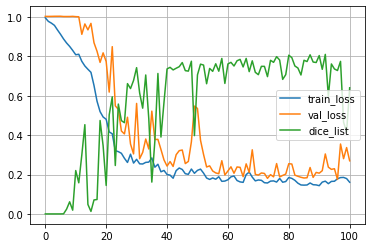

In [53]:
# Plot training loss and validation loss
plt.grid('on')
plt.plot(np.arange(NUM_EPOCH+1),train_loss_list,label='train_loss')
plt.plot(np.arange(NUM_EPOCH+1),val_loss_list, label='val_loss')
plt.plot(np.arange(NUM_EPOCH+1),dice_list, label='dice_list')
plt.legend()

# 6.Test

## Reload the model

In [62]:
checkpoint_path = SAVE_PATH +'MRISegEpoch100.pth'

net = AttU_Net(4,1).to(device)
net.load_state_dict(torch.load(checkpoint_path))
net.eval()

AttU_Net(
  (Maxpool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05,

## Reload the data with mask1 and mask2

In [55]:
test_dataset_mask1 = MRIDataset(test_img_list, test_label1_list, test_label2_list, RULE = 'mask1', IF_TRAIN= False)
test_dataset_mask2 = MRIDataset(test_img_list, test_label1_list, test_label2_list, RULE = 'mask2', IF_TRAIN= False)

  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-10-976d5a4983b3>:25: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
<ipython-input-10-976d5a4983b3>:28: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
<ipython-input-10-976d5a4983b3>:31: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more pr

In [63]:
test_loader_mask1 = torch.utils.data.DataLoader(test_dataset_mask1, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         num_workers=0)
test_loader_mask2 = torch.utils.data.DataLoader(test_dataset_mask2, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         num_workers=0)

## Test with mask1 and mask2

In [64]:
test_loss, test_dice = eval_epoch(net, test_loader_mask1, dice_coeff, criterion)
test_loss, test_dice = eval_epoch(net, test_loader_mask2, dice_coeff, criterion)

Dice: 0.772  Val Loss: 0.232 
Dice: 0.778  Val Loss: 0.294 


## Dispaly the output mask

In [65]:
img, mask1 = test_dataset_mask1[0]
img, mask2 = test_dataset_mask2[0]
result = net(img.unsqueeze(0).to(device)).detach()
mask_pred = result.cpu().numpy()[0,0,:,:,:]
mask_pred[mask_pred>0.2] = 1
mask_pred[mask_pred<=0.2] = 0
print(mask_pred.shape)

(181, 217, 181)


Manual Volume for mask1: 32333.0
Manual Volume for mask2: 34620.0
Segmentation Volume: 25836.0


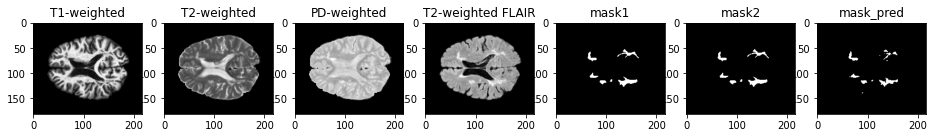

In [66]:
plt.figure(figsize = (16,32))
plt.subplot(1,7,1)
plt.imshow(img[0,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T1-weighted')
plt.subplot(1,7,2)
plt.imshow(img[1,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T2-weighted')
plt.subplot(1,7,3)
plt.imshow(img[2,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('PD-weighted')
plt.subplot(1,7,4)
plt.imshow(img[3,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T2-weighted FLAIR')
plt.subplot(1,7,5)
plt.imshow(mask1.cpu().numpy()[:,:,90],'gray')
plt.title('mask1')
plt.subplot(1,7,6)
plt.imshow(mask1.cpu().numpy()[:,:,90],'gray')
plt.title('mask2')
plt.subplot(1,7,7)
plt.imshow(mask_pred[:,:,90],'gray')
plt.title('mask_pred')

print('Manual Volume for mask1:',mask1.cpu().numpy().sum())
print('Manual Volume for mask2:',mask2.cpu().numpy().sum())
print('Segmentation Volume:',mask_pred.sum())

In [67]:
img, mask1 = test_dataset_mask1[1]
img, mask2 = test_dataset_mask2[1]
result = net(img.unsqueeze(0).to(device)).detach()
mask_pred = result.cpu().numpy()[0,0,:,:,:]
mask_pred[mask_pred>0.2] = 1
mask_pred[mask_pred<=0.2] = 0
print(mask_pred.shape)

(181, 217, 181)


Manual Volume for mask1: 5990.0
Manual Volume for mask2: 10545.0
Segmentation Volume: 9385.0


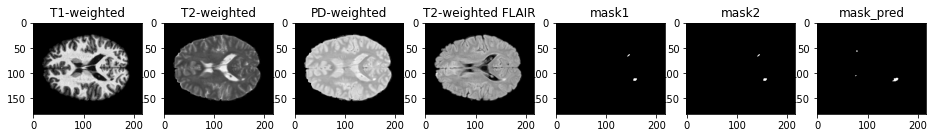

In [68]:
plt.figure(figsize = (16,32))
plt.subplot(1,7,1)
plt.imshow(img[0,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T1-weighted')
plt.subplot(1,7,2)
plt.imshow(img[1,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T2-weighted')
plt.subplot(1,7,3)
plt.imshow(img[2,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('PD-weighted')
plt.subplot(1,7,4)
plt.imshow(img[3,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T2-weighted FLAIR')
plt.subplot(1,7,5)
plt.imshow(mask1.cpu().numpy()[:,:,90],'gray')
plt.title('mask1')
plt.subplot(1,7,6)
plt.imshow(mask1.cpu().numpy()[:,:,90],'gray')
plt.title('mask2')
plt.subplot(1,7,7)
plt.imshow(mask_pred[:,:,90],'gray')
plt.title('mask_pred')

print('Manual Volume for mask1:',mask1.cpu().numpy().sum())
print('Manual Volume for mask2:',mask2.cpu().numpy().sum())
print('Segmentation Volume:',mask_pred.sum())